In [1]:
import numpy as np
import time
import xarray as xr
import numpy as np
import math
import calendar
import warnings
import sys
from operator import attrgetter
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import timedelta, datetime, date
from parcels import FieldSet, ParticleSet, JITParticle, ScipyParticle
from parcels import ErrorCode, Variable
from parcels import plotTrajectoriesFile, AdvectionRK4_3D, AdvectionRK4
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from datetime import timedelta
from main import paths, EUC_particles, ofam_fieldset, get_date, Age
from main import plot3D, ParticleFile_transport, DeleteParticle, plot3D

fpath, dpath, xpath = paths()

# Define Fieldset and ParticleSet parameters.
# Start and end dates.
date_bnds = [get_date(2000, 1, 1), get_date(2000, 1, 7)]
# Meridional and vertical distance between particles to release.
dy, dz = 0.8, 25
p_lats = np.arange(-2.4, 2.4 + dy, dy)
p_depths = np.array([100, 300])
p_lons = np.array([165])

dt = timedelta(minutes=-60)
repeatdt = timedelta(days=2)
# Run for the number of days between date bounds.
runtime = timedelta(days=(date_bnds[1] - date_bnds[0]).days)
outputdt = timedelta(minutes=240)

# Extra stuff.
add_transport = False
write_fieldset = False
plot_ParticleFile = False 

In [7]:
print('Executing: {} to {}'.format(date_bnds[0], date_bnds[1]))
# print('Repeat release: {} days'.format(repeatdt.days))
# print('Release longitudes:', len(p_lons))
print('Timestep (dt): {:.0f} minutes'.format(24*60 - dt.seconds/(60)))
# print('Set particles released each repeatdt:', len(p_depths)*len(p_lats))

fieldset = ofam_fieldset(date_bnds)
fieldset.mindepth = fieldset.U.depth[0] 

Executing: 2000-01-01 00:00:00 to 2000-01-07 00:00:00
Timestep (dt): 60 minutes
ofam_fieldset: 0 hours, 0 mins, 00.22 secs (03:45am)


In [8]:
def Age(particle, fieldset, time):
    # Update particle age.
    particle.age = particle.age + math.fabs(particle.dt)  
def DeleteWestward(particle, fieldset, time):
    # Delete particle if the initial zonal velocity is westward (negative).
    if particle.age == 0. and particle.u < 0:
        particle.delete()
class tparticle(JITParticle):   
    """ Particle class that saves particle age and zonal velocity.
    """
    # The age of the particle.
    age = Variable('age', dtype=np.float32, initial=0.)
    # The velocity of the particle.
    u = Variable('u', dtype=np.float32, initial=fieldset.U)
pclass = tparticle
# Create name to save particle file (looks for unsaved filename).
i = 0
while dpath.joinpath('ParticleFile_{}-{}_v{}i.nc'.format(*[d.year 
                     for d in date_bnds], i)).exists():
    i += 1

pfile = dpath.joinpath('ParticleFile_{}-{}_v{}i.nc'.format(*[d.year 
                      for d in date_bnds], i))
print('Executing:', pfile.stem)
lats = np.tile(p_lats, len(p_depths)*len(p_lons))
depths = np.tile(np.repeat(p_depths, len(p_lats)), len(p_lons))
lons = np.repeat(p_lons, len(p_depths)*len(p_lats))
pset = ParticleSet(fieldset=fieldset, pclass=pclass,
                             lon=lons, lat=lats, depth=depths, 
                             time=fieldset.U.grid.time[-1], repeatdt=repeatdt)
for p in pset:
    print(p)

Executing: ParticleFile_2000-2000_v0i


FieldSamplingError: U sampled at (165.000000, 0.000000, 100.000000)

In [ ]:
# Output particle file p_name and time steps to save.
output_file = pset.ParticleFile(dpath.joinpath(pfile.stem), outputdt=outputdt)
kernels = pset.Kernel(DeleteWestward) + pset.Kernel(Age) + AdvectionRK4_3D
pset.execute(kernels, runtime=runtime, dt=dt, output_file=output_file, 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, 
             verbose_progress=True)

In [ ]:
print(fieldset.U.grid.time[0], fieldset.U.grid.time[-1])
print(len(pset))
for p in pset:
    print(p)

In [2]:
from pathlib import Path
pfile = dpath.joinpath('ParticleFile_1979-1989_v3.nc')

In [3]:
plot3D(pfile)

plot3D: 0 hours, 46 mins, 23.90 secs (11:47am)


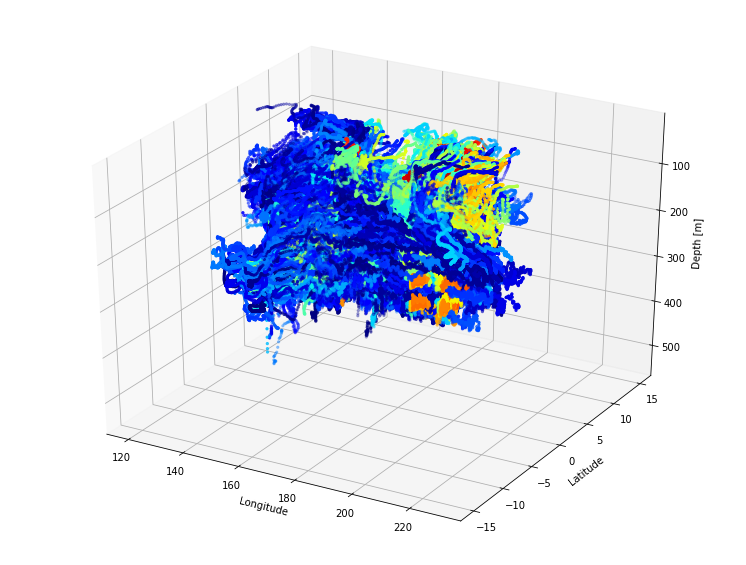

plot3D: 0 hours, 4 mins, 54.84 secs (05:44am)


In [12]:
from pathlib import Path
pfile = dpath.joinpath('ParticleFile_1979-1979_v1i.nc')
plot3D(pfile)

In [ ]:
ds.time[0]

In [ ]:
from main import remove_westward_particles
remove_westward_particles(pset)

In [ ]:
2592000/(60*60*24)

In [ ]:
timedelta(seconds=2592000 - 2419200)

In [ ]:
date_bnds[1] - date_bnds[0])

In [ ]:
5*60

In [ ]:
fieldset.U.depth

In [4]:
import numpy as np
from datetime import timedelta
from main import paths, EUC_particles, ofam_fieldset, get_date
from main import plot3D, ParticleFile_transport

fpath, dpath, xpath = paths()

# Define Fieldset and ParticleSet parameters.
# Start and end dates.
date_bnds = [get_date(1980, 1, 1), get_date(1980, 1, 3)]
# Meridional and vertical distance between particles to release.
dy, dz = 0.2, 25
p_lats = np.round(np.arange(-2.4, 2.4 + dy, dy), 2)
p_depths = np.arange(25, 300 + dz, dz)
# Longitudes to release particles.
p_lons = np.array([165, 190, 200])
dt = -timedelta(minutes=120)
repeatdt = timedelta(days=6)
# Run for the number of days between date bounds.
runtime = timedelta(days=(date_bnds[1] - date_bnds[0]).days)
outputdt = timedelta(days=1)

In [5]:
fieldset = ofam_fieldset(date_bnds)
pset_start = fieldset.U.grid.time[-1]
pfile = EUC_particles(fieldset, date_bnds, p_lats, p_lons, p_depths,  
                      dt, pset_start, repeatdt, runtime, outputdt, 
                      remove_westward=True)

ofam_fieldset: 0 hours, 0 mins, 00.30 secs (03:35am)
Executing: ParticleFile_1979-1979_v0i


KeyboardInterrupt: 